# 트랜스포머로 만드는 대화형 챗봇
한국어 데이터로 챗봇 만들기

### Step 1. 데이터 수집하기
### Step 2. 데이터 전처리하기
### Step 3. SubwordTextEncoder 사용하기
### Step 4. 모델 구성하기
### Step 5. 모델 평가하기

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 포지셔널 행렬 구현

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # 짝수 인덱스에는 sin 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 홀수 인덱스에는 cos 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 스케일드 닷 프로덕트 어텐션 함수 구현

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티헤드 어텐션 구현

In [5]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.query_dense(key)
    value = self.query_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 패딩 마스킹 구현

In [6]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 록 어헤드 마스킹
다음 단어 가리기
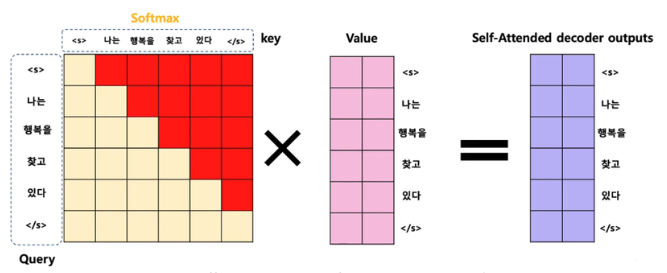

In [7]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더 구현
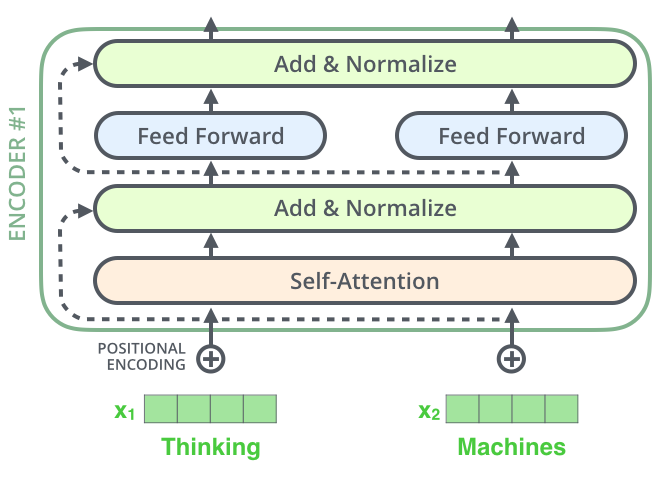

In [8]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기
임베디층 - 포지셔널 인코딩 층 연결

In [9]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더 구현
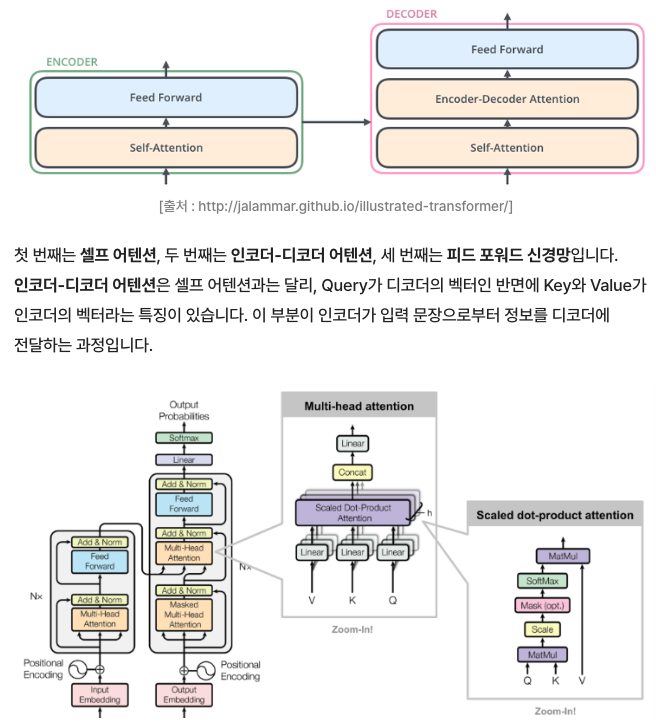

In [10]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기

In [11]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Step 1. 데이터 수집하기
- Chatbot_data
```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

In [12]:
# 데이터 로드
data_path = '~/aiffel/Aiffel_quest_rs/Exploration/Ex07/ChatbotData.csv'
chatbot_data = pd.read_csv(data_path)

print(chatbot_data.head())
print(chatbot_data.columns)

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
Index(['Q', 'A', 'label'], dtype='object')


In [46]:
# Q와 A 열을 각각 리스트로 변환
questions = []
answers = []

# 질문과 답변 데이터를 리스트에 추가
for index, row in chatbot_data.iterrows():
    questions.append(row['Q'])  # 질문 리스트에 추가
    answers.append(row['A'])  # 답변 리스트에 추가

In [14]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [15]:
print('전처리 후의 30번째 질문 샘플: {}'.format(questions[30]))
print('전처리 후의 30번째 답변 샘플: {}'.format(answers[30]))

전처리 후의 30번째 질문 샘플: 가족들이랑 서먹해
전처리 후의 30번째 답변 샘플: 다들 바빠서 이야기할 시간이 부족했나봐요.


## Step 2. 데이터 전처리하기
1. 한글과 구두점 제외
2. 형태소 분석
3. 불용어 제거

In [16]:
!pip install konlpy # 형태소 분석

In [16]:
# 데이터 전처리
def preprocess_sentence(sentence):
    sentence = sentence.lower()  # 소문자 변환
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 중복된 공백 제거
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)  # 한글과 구두점 제외 제거
    sentence = sentence.strip()
    return sentence

# 전처리 적용
chatbot_data['Q'] = chatbot_data['Q'].apply(preprocess_sentence)
chatbot_data['A'] = chatbot_data['A'].apply(preprocess_sentence)

print(chatbot_data.head())

                Q             A  label
0           시 땡 !   하루가 또 가네요 .      0
1      지망 학교 떨어졌어    위로해 드립니다 .      0
2     박 일 놀러가고 싶다  여행은 언제나 좋죠 .      0
3  박 일 정도 놀러가고 싶다  여행은 언제나 좋죠 .      0
4             심하네   눈살이 찌푸려지죠 .      0


In [17]:
import re
from konlpy.tag import Okt

# 형태소 분석기와 불용어 목록 정의
okt = Okt()

# 불용어 리스트 정의 (필요에 따라 확장 가능)
stopwords = ['그리고', '하지만', '그런데', '즉', '또한']

# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower()     # 1. 소문자 변환 (한국어에는 큰 영향을 미치지 않지만 영문 대비용)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # 2. 구두점 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)    # 3. 중복된 공백 제거
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)    # 4. 한글과 구두점 이외의 문자 제거
    
    tokens = okt.morphs(sentence, stem=True)     # 5. 형태소 분석-어간추출

    tokens = [word for word in tokens if word not in stopwords]    # 6. 불용어 제거

    sentence = " ".join(tokens)    # 7. 최종 문장 생성
    sentence = sentence.strip()    # 8. 좌우 공백 제거

    return sentence

# 전처리 적용
chatbot_data['Q'] = chatbot_data['Q'].apply(preprocess_sentence)
chatbot_data['A'] = chatbot_data['A'].apply(preprocess_sentence)

# 전처리된 데이터 확인
print(chatbot_data.head())


                 Q              A  label
0            시 땡 !    하루 가 또 가다 .      0
1       지망 학교 떨어지다    위로 하다 드리다 .      0
2     박 일 놀다 가다 싶다  여행 은 언제나 좋다 .      0
3  박 일 정도 놀다 가다 싶다  여행 은 언제나 좋다 .      0
4              심하다    눈살 이 찌푸리다 .      0


In [18]:
questions

['12시 땡!',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨',
 'SNS보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다.',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지?',
 '가족 있어?',
 '가족관계 알려 줘',
 '가족끼리 여행간다.',
 '가족들 보고 싶어',
 '가족들이랑 서먹해',
 '가족들이랑 서먹해졌어',
 '가족들이랑 어디 가지?',
 '가족들이랑 여행 갈거야',
 '가족여행 가야지',
 '가족이 누구야?',
 '가족이랑 여행 가려고',
 '가족한테 스트레스 풀었어',
 '가출할까?',
 '가출해도 갈 데가 없어',
 '간만에 떨리니까 좋더라',
 '간만에 쇼핑 중',
 '간만에 휴식 중',
 '간식 뭐 먹을까',
 '간식 추천',
 '간장치킨 시켜야지',
 '간접흡연 싫어',
 '갈까 말까 고민 돼',
 '갈까 말까?',
 '감 말랭이 먹고 싶다.',
 '감 말랭이 먹어야지',
 '감기 같애',
 '감기 걸린 것 같아',
 '감기 기운이 있어',
 '감기 들 거 같애',
 '감기가 오려나',
 '감기약이 없어',
 '감기인거 같애',
 '감미로운 목소리 좋아',
 '감정이 쓰레기통처럼 엉망진창이야',
 '감정컨트롤을 못하겠어',
 '감정컨트롤이 안돼',
 '감히 나를 무시하는 애가 있어',
 '갑자기 나쁜 생각이 막 들더라',
 '갑자기 눈물 나',

In [19]:
answers

['하루가 또 가네요.',
 '위로해 드립니다.',
 '여행은 언제나 좋죠.',
 '여행은 언제나 좋죠.',
 '눈살이 찌푸려지죠.',
 '다시 새로 사는 게 마음 편해요.',
 '다시 새로 사는 게 마음 편해요.',
 '잘 모르고 있을 수도 있어요.',
 '시간을 정하고 해보세요.',
 '시간을 정하고 해보세요.',
 '자랑하는 자리니까요.',
 '그 사람도 그럴 거예요.',
 '그 사람도 그럴 거예요.',
 '혼자를 즐기세요.',
 '돈은 다시 들어올 거예요.',
 '땀을 식혀주세요.',
 '어서 잊고 새출발 하세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '빨리 집에 돌아가서 끄고 나오세요.',
 '다음 달에는 더 절약해봐요.',
 '따뜻하게 사세요!',
 '다음 달에는 더 절약해봐요.',
 '가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요.',
 '저도요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '다들 바빠서 이야기할 시간이 부족했나봐요.',
 '온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '좋은 생각이에요.',
 '더 가까워질 기회가 되겠네요.',
 '저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '좋은 생각이에요.',
 '정말 후회할 습관이에요.',
 '무모한 결정을 내리지 마세요.',
 '선생님이나 기관에 연락해보세요.',
 '떨리는 감정은 그 자체로 소중해요.',
 '득템했길 바라요.',
 '휴식도 필요하죠.',
 '단짠으로 두 개 사는게 진리죠.',
 '단짠으로 두

## Step 3. SubWordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징
-> 내부 단어 토크나이저인 SubwordTextEncoder 사용

### 단어장 만들기
질문과 답변 데이터셋 모두 사용해 만듬

In [20]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [21]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


### 각 단어를 고유한 정수로 인코딩 & 패딩

In [22]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


In [23]:
# 샘플 길이 확인
q_len = [len(s.split()) for s in questions]
a_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


In [24]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 21
print(MAX_LENGTH)

21


In [25]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 21 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 21으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11800
필터링 후의 답변 샘플 개수: 11800


In [26]:
# 토큰화된 결과 확인
sample_sentence = "안녕하세요"
encoded_sentence = tokenizer.encode(sample_sentence)
print("인코더 문장:", encoded_sentence)
decoded_sentence = tokenizer.decode(encoded_sentence)
print("디코더 문장:", decoded_sentence)

인코더 문장: [4151]
디코더 문장: 안녕하세요


### 교사 강요(Teacher Forcing) 사용
훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축

In [27]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
트랜스포머 모델 구현

In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 파라미터 설정 및 모델 생성


In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

# 모델 설정
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2883072     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수 : 4
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원 : 512
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 : 16
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기 : 1024
DROPOUT = 0.2 # 드롭아웃의 비율 : 0.2

# 모델 설정
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    10493952    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수
레이블인 시퀀스에 패딩이 되있기에, loss를 계산할 때 패딩 마스크 적용

In [30]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀된 학습률(learning rate)
커스텀 학습률 스케줄러를 통한 아담 옵티마이저 사용

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

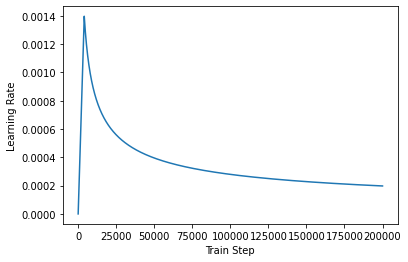

In [32]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Step 5. 모델 평가하기

### 모델 컴파일

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
# 모델 학습
EPOCHS = 50  # 학습할 에포크 수

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 16s 38ms/step - loss: 2.8287 - accuracy: 0.0595
Epoch 2/50
185/185 [==============================] - 7s 37ms/step - loss: 2.2780 - accuracy: 0.0967
Epoch 3/50
185/185 [==============================] - 7s 39ms/step - loss: 1.9335 - accuracy: 0.0996
Epoch 4/50
185/185 [==============================] - 7s 37ms/step - loss: 1.7790 - accuracy: 0.1076
Epoch 5/50
185/185 [==============================] - 7s 38ms/step - loss: 1.6615 - accuracy: 0.1144
Epoch 6/50
185/185 [==============================] - 7s 37ms/step - loss: 1.5424 - accuracy: 0.1230
Epoch 7/50
185/185 [==============================] - 7s 38ms/step - loss: 1.4181 - accuracy: 0.1348
Epoch 8/50
185/185 [==============================] - 7s 37ms/step - loss: 1.2879 - accuracy: 0.1476
Epoch 9/50
185/185 [==============================] - 7s 38ms/step - loss: 1.1535 - accuracy: 0.1603
Epoch 10/50
185/185 [==============================] - 7s 38ms/step - loss: 1.0188 - accur

### 챗봇 테스트하기

In [35]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [36]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

#### 챗봇 대답을 얻어보자!

In [37]:
sentence_generation('나 기분이 안좋아')

입력 : 나 기분이 안좋아
출력 : 서로에게 맞춰갈 거예요.


'서로에게 맞춰갈 거예요.'

In [38]:
sentence_generation('너 고기 좋아해?')

입력 : 너 고기 좋아해?
출력 : 저기압에는 고기앞이죠.


'저기압에는 고기앞이죠.'

In [39]:
sentence_generation('나 잘생겼어?')

입력 : 나 잘생겼어?
출력 : 네 잘생겼어요.


'네 잘생겼어요.'

In [44]:
sentence_generation('학교 가기 싫어')

입력 : 학교 가기 싫어
출력 : 학교 다닐 때가 좋은 거예요.


'학교 다닐 때가 좋은 거예요.'

### 챗봇 채팅 프로그램 만들기

In [45]:
# sentence_generation 함수 - 사용자가 입력한 문장을 예측하여 답변을 생성
def sentence_generation(sentence):
    # 1. 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)  # 이미 구현된 decoder_inference 사용
    
    # 2. 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    
    return predicted_sentence

# 채팅형태로 사용자 입력을 받는 함수
def chatbot():
    print("챗봇과의 대화를 시작합니다. 종료하려면 '종료'라고 입력하세요.")

    while True:
        # 사용자 입력 받기
        user_input = input("나: ")
        
        # '종료' 입력 시 대화 종료
        if user_input.lower() == '종료':
            print("챗봇: 대화를 종료합니다.")
            break

        # sentence_generation을 통해 모델의 응답을 생성
        response = sentence_generation(user_input)
        
        # 챗봇 응답 출력
        print(f"챗봇: {response}")

# 채팅 시작
chatbot()

챗봇과의 대화를 시작합니다. 종료하려면 '종료'라고 입력하세요.
나: 오늘 날씨 어때?
챗봇: 하늘을 보고 웃어보세요.
나: 그러면 날씨가 맑아지니?
챗봇: 거예요.
나: 하늘을 보고 웃으면 날씨가 좋아지냐고
챗봇: 오늘은 쉬면서 보세요.
나: 하늘도 힘들대?
챗봇: 오늘은 쉬면서 보세요.
나: 나랑 말하기 싫어?
챗봇: 하세요.
나: 너랑 말 안할래
챗봇: 노력하고 있나봐요.
나: 종료
챗봇: 대화를 종료합니다.
